In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timestamp, DateOffset
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import umap

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
df_gender = pd.read_csv('data/customers_gender_train.csv')
df_mcc = pd.read_csv('data/tr_mcc_codes.csv', sep=';')

In [3]:
df_transactions = pd.read_csv('data/transactions.csv.gz')

In [4]:
df_tr = pd.read_csv('data/tr_types.csv', sep=';')

In [5]:
def preproc_transactions(df_transactions):
    sec_per_day = 86400
    sec_per_hour = 3600
    
    start_date = 1420070400 - 154 * sec_per_day - 3 * sec_per_hour
    
    df_transactions.loc[:, 'day'] = df_transactions.tr_datetime\
                                               .str.split(' ')\
                                               .str.get(0)\
                                               .astype(int)
    df_transactions.loc[:, 'time_raw'] = df_transactions.tr_datetime\
                                                    .str.split(' ')\
                                                    .str.get(1)

    # set temp dt
    df_transactions.loc[:, 'dt_temp'] = pd.to_datetime(df_transactions.loc[:, 'time_raw'], 
                                                    format='%H:%M:%S')\
                                        + DateOffset(years=115)
    
    df_transactions = df_transactions.assign(dt = lambda x: x.dt_temp.astype(np.int64) // 10**9
                                             + (x.day - 153) * sec_per_day)\
                                     .assign(weekday = lambda x: ((x.day + 4) % 7 + 1))
        
    df_transactions.loc[:, 'datetime'] = pd.to_datetime(df_transactions.dt, unit='s')
    #df_transactions.loc[:, 'date'] = df_transactions.loc[:, 'datetime'].dt.strftime('%Y-%m-%d')
    #df_transactions.loc[:, 'hour'] = df_transactions.loc[:, 'datetime'].dt.strftime('%H')
    df_transactions.loc[:, 'month'] = df_transactions.loc[:, 'datetime'].dt.strftime('%Y-%m')
    
    df_transactions = df_transactions.drop(['dt_temp', 'time_raw', 'tr_datetime'], axis=1)
    
    df_transactions.loc[:, 'amount'] = np.round(df_transactions.loc[:, 'amount']/(np.pi**np.exp(1)))
    
    df_transactions.loc[:, 'turnover'] = df_transactions.loc[:, 'amount'].apply(lambda x: x if x>0 else -x) 
            
    return df_transactions

In [6]:
df_transactions = df_transactions.pipe(preproc_transactions)

In [7]:
def FeatureExtraction(tr_types, trans, genders):
    #скопируем, чтобы не трогать старое
    new_tr_types = tr_types.copy()
    new_trans    = trans.copy()
    
    #Получение оборотов в выходные/будни
    wknd = new_trans[(new_trans.weekday == 6) | (new_trans.weekday == 7)]
    wknd.loc[:,'wknd_turn']=wknd.loc[:,'turnover']
    wknd.drop(['turnover'], axis=1, inplace=True)
    wd   = new_trans[(new_trans.weekday != 6) & (new_trans.weekday != 7)]
    wd.loc[:,'wd_turn']=wd.loc[:,'turnover']
    wd.drop(['turnover'], axis=1, inplace=True)
    wknd_p = wknd.pivot_table(index='customer_id', values='wknd_turn', aggfunc='sum',fill_value=0)
    wd_p = wd.pivot_table(index='customer_id', values='wd_turn', aggfunc='sum',fill_value=0)
    
    #Получение процента оборотов по mcc-кодам от всех оборотов по ДФ
    byCustomer = df_transactions.pivot_table(values='turnover', index='customer_id', aggfunc='sum', fill_value=0)
    byMCC = df_transactions.pivot_table(values='turnover', index='customer_id',columns='mcc_code', aggfunc='sum',fill_value=0)
    byMCC = byMCC.rename(lambda x: 'mcc_{}_perc'.format(x), axis=1)
    TurnOvers=byCustomer.merge(byMCC, how='left',on='customer_id')#.merge(wknd_p, how='left',on='customer_id').merge(wd_p, how='left',on='customer_id',)
    TurnOvers.fillna(0)
    
    for colname in TurnOvers.columns:
        if colname =='turnover':
            continue
        #if type(TurnOvers[colname]) == type(0.0):
        TurnOvers[colname]=TurnOvers[colname]/TurnOvers.turnover
        #else:
        #    TurnOvers[colname]=0

    #добавим признаки к типам транзакций
    df_tr['isReturn'] = df_tr['tr_description'].apply(lambda x: 1 if x.find('Возврат') > -1 else 0)
    df_tr['isTransfer'] = df_tr['tr_description'].apply(lambda x: 1 if x.find('Перевод на карту') > -1 else 0)
    df_tr['isTransferOut'] = df_tr['tr_description'].apply(lambda x: 1 if x.find('Списание с карты по операции') > -1 else 0)
    
    new_trans = new_trans.merge(new_tr_types, on='tr_type', how='left')
    
    #группируем по признакам
    onFeat = new_trans.pivot_table(values=['isReturn','isTransfer', 'isTransferOut'], index='customer_id',aggfunc='max',fill_value=0)
    
    features = TurnOvers.merge(onFeat, on='customer_id',how='left')
    
    features = genders.merge(features, on='customer_id', how='left')
    
    features.drop(['turnover','customer_id'], axis=1,inplace=True)
   
    return features

In [9]:
features = FeatureExtraction(df_tr, df_transactions, df_gender)

C:\Conda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Conda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Conda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=error

In [11]:
label = 'gender'
idx_features = features.columns != label

In [12]:
X = features.loc[:, idx_features].values
y = features.loc[:, ~idx_features].values.flatten()

In [52]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=128))
])

In [53]:
x_train, x_text, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [54]:
model.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=128, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [55]:
y_hat = model.predict(x_text)

In [56]:
print(roc_auc_score(y_test, y_hat))

0.7205772902815101


In [18]:
umap_emb = umap.UMAP()
show_reduced = umap_emb.fit_transform(X)

C:\Conda\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 9 separate connected components using meta-embedding (experimental)
  n_components


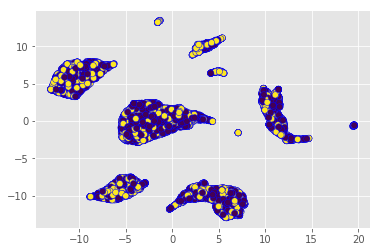

In [19]:
fig, ax = plt.subplots()
ax.scatter(show_reduced[:, 0],show_reduced[:, 1],c=y, edgecolor='b', s=40)
plt.show()


In [25]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, rand

In [27]:
# Задаем пространство поиска
space4_lm = {
    'lm_penalty': hp.choice('penalty', ['l1', 'l2']),
    'lm_C': hp.loguniform('C', -5, 3),
    'lm_class_weight': hp.choice('class_weight', [None, 'balanced']),
    'lm_random_state': 128,
    'scaler_type': hp.choice('scaler_type', ['standart', 'robust']),
    'scaler_centering': hp.choice('scaler_centering', [False, True])
}

In [37]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [40]:
def run_trials_template(X, y, params, evals=100):

    def hyperopt_cv(X, y, params):
        
        X_ = X.copy()
        
        # Отделяем параметры лог регрессии в отдельный словарь
        lm_params = {}
        for k, v in params.items():
            if k.startswith('glob'):
                continue                
            elif k.startswith('lm'):
                lm_params[k.split('_', 1)[1]] = v
        
        # Задаем шкалирование
        if params['scaler_type'] == 'standart':
            scaler = StandardScaler(with_mean=params['scaler_centering'])
        else:
            assert params['scaler_type'] == 'robust'
            scaler = RobustScaler(with_centering=params['scaler_centering'])
        
        # Создаем лог рег с нужными параметрами
        clf = LogisticRegression(**lm_params)
        
        # Итоговый пайплайн
        model = Pipeline([
            ('scaler', scaler),
            ('clf', clf)
        ])

        # Схема кросс-валидации
        n_splits = 5
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, 
                             random_state=128)
        scores = cross_val_score(model, X_, y,
                                 scoring='roc_auc', 
                                 cv=cv, 
                                 n_jobs=-1)

        # Возвращаем среднее значение метрики и отклонение (на всякий случай)
        return scores.mean(), scores.std()

    def f(params):
        acc, std = hyperopt_cv(X, y, params)
        return {'loss': -acc, 'qscore': -acc, 'qscore_std': std, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(f, 
                params, 
                algo=tpe.suggest, 
                max_evals=evals, 
                trials=trials, 
                verbose=1)
    
    return trials

In [44]:
def trials_df(trials):
    '''
    Функция форматирует результаты hyperopt в dataframe
    '''
    tr_dict = []
    for t in trials:
        trial = dict()
        for k, v in t['misc']['vals'].items():
            trial[k] = v[0]

        trial['qscore'] = -t['result']['qscore']
        trial['qscore_std'] = t['result']['qscore_std']
        tr_dict.append(trial)

    df_res = pd.DataFrame.from_dict(tr_dict)
    df_res = df_res.sort_values('qscore', ascending=False)
    
    return df_res

In [41]:
# Запускаем поиск
trials = run_trials_template(X, y, space4_lm, evals=40)

In [45]:
df_trials = trials_df(trials)

In [46]:
df_trials.head()

,C,class_weight,penalty,qscore,qscore_std,scaler_centering,scaler_type
20,19.985949,1,0,0.808045,0.007044,0,1
35,19.790154,1,0,0.808019,0.007026,0,1
28,19.488443,1,0,0.807974,0.007053,0,1
25,17.818399,1,0,0.807867,0.006970,0,1
24,18.119946,1,0,0.807855,0.007024,0,1


In [58]:
bestmodel = Pipeline([
    ('scaler', RobustScaler(with_centering=False)),
    ('clf', LogisticRegression(penalty='l1', C=19.985949, class_weight='balanced'))   
]
)
    

In [59]:
bestmodel.fit(x_train, y_train)
y_hat = bestmodel.predict(x_text)
print(roc_auc_score(y_test, y_hat))

0.7241305002242828
